# YAML-NIFTy

In [1]:
import jax
import jax.numpy as jnp
import nifty8.re as jft
import numpy as np
import matplotlib.pyplot as plt

from aim_resolve import OptimizeKLConfig, optimize_kl, random_init

jax.config.update('jax_enable_x64', True)

In [2]:
# helper function for plotting
def plot_arr(
        arr,
        name=None,
        odir=None,
        cmap='inferno',
        cbar = True,
        **kwargs,
):
    plt.imshow(arr.T, cmap=cmap, origin='lower', **kwargs)
    plt.colorbar() if cbar else None
    plt.title(name) if name is not None else None
    plt.tight_layout()
    plt.show()
    plt.close()

In [3]:
# diffuse signal model (gaussian process)
def signal_diffuse(*,
        shape,
        offset_mean,
        offset_std,
        fluctuations,
        loglogavgslope,
        flexibility,
        asperity,
        distances=1.0,
        prefix='df',
):
    cfm = jft.CorrelatedFieldMaker(f'{prefix} ')
    cfm.set_amplitude_total_offset(offset_mean, offset_std)
    cfm.add_fluctuations(
        shape,
        distances,
        fluctuations,
        loglogavgslope,
        flexibility,
        asperity,
        prefix='',
        non_parametric_kind='power'
    )
    return cfm.finalize()



# Point insertion model
class PointModel(jft.Model):
    def __init__(self, op, coos, shape):
        self.op = op
        self.coos = coos.T
        self.shape = shape
        super().__init__(init=self.op.init)

    def __call__(self, x):
        res = jnp.zeros(shape=self.shape)
        if self.coos.size > 0:
            res = res.at[..., self.coos[0], self.coos[1]].set(self.op(x))
        return res



# point source signal model (normal distribution)
def signal_points(*,
        shape,
        coos,
        mean,
        std,
        prefix='ps',
):
    coos = np.array(coos)
    nop = jft.NormalPrior(mean, std, name=prefix, shape=coos.shape[0])
    return PointModel(nop, coos, shape)
    

# combined signal model
class SignalModel(jft.Model):
    def __init__(self, diffuse, points=None):
        self.diffuse = diffuse
        self.points = points
        super().__init__(init=diffuse.init | points.init if points is not None else diffuse.init)

    def __call__(self, x):
        return self.diffuse(x) + self.points(x) if self.points is not None else self.diffuse(x)



# likelihood function
def likelihood(*, 
        signal,
        data,
        noise_var=0.01,
):
    lh = dict(
        model = signal,
        data = data,
        noise_cov_inv = lambda x: noise_var**-2 * x
    )
    return lh


# function to generate mock data
def data(*,
        signal,
        seed=1234,
        noise_var=0.01,
):
    key = jax.random.PRNGKey(seed)
    k_p, k_n = jax.random.split(key)
    pos_truth = jft.random_like(k_p, signal.domain)
    signal_truth = signal(pos_truth)
    noise_cov = lambda x: noise_var**2 * x
    noise_truth = ((noise_cov(jft.ones_like(signal.target)))**0.5) * jft.random_like(k_n, signal.target)
    return signal_truth + noise_truth



# transition function
def transition(*,
        sig_old,
        sig_new,
        opt_dct,
        margin=1,
        noise_var=0.01,
        odir=None,
):

    def tr(key, samples, it):
        # get reconstruction of the previous iteration
        rec = sig_old(samples.pos)

        # create a mask around the coordinates of the point sources
        coos = sig_new.points.coos
        mask = np.ones_like(rec)
        for x, y in zip(coos[0], coos[1]):
            mask[max(0, x-margin):min(rec.shape[0], x+margin+1), max(0, y-margin):min(rec.shape[1], y+margin+1)] = 0
        plot_arr(mask, name='mask', odir=odir)

        # mask the diffuse part of the new signal model at the coordinates of the point sources
        sig_df = jft.Model(lambda x: sig_new.diffuse(x) * mask, init=sig_new.diffuse.init)

        # add some noise to the reconstruction 
        k_n, k_o, k_i = jax.random.split(key, 3)
        noise_cov = lambda x: noise_var**2 * x
        noise = ((noise_cov(jft.ones_like(sig_df.target)))**0.5) * jft.random_like(k_n, sig_df.target)
        data = rec + noise

        # setup the likelihood function
        lh = dict(model=sig_df, data=data, noise_cov_inv=lambda x: noise_var**-2 * x)

        # optimize the new diffuse signal model
        samples, state = optimize_kl(lh, key=k_o, **opt_dct)
        pos_new = samples.pos

        # plot the transition of the background
        plot_arr(sig_df(pos_new), name='trans', odir=odir)

        # randomly initialize the point sources
        pos_new = random_init(k_i, sig_new, pos_new, 0.1)

        samples = jft.Samples(pos=pos_new, samples=None, keys=None)

        return samples
    
    return tr

In [4]:
# builders dictionary to link the yaml-file sections with the functions
builders_dct = {
    'data': data,
    'lh.1': likelihood,
    'sig.1': SignalModel,
    'sig_df.1': signal_diffuse,
    'lh.2': likelihood,
    'sig.2': SignalModel,
    'sig_df.2': signal_diffuse,
    'sig_ps.2': signal_points,
    'trans.2': transition,
}

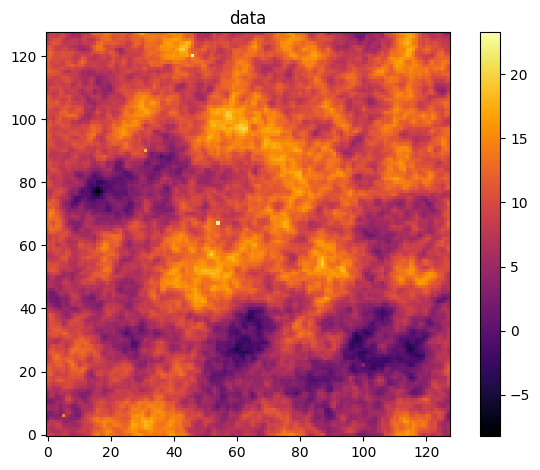

OPTIMIZE_KL: Starting 0001


s == p == set()


N: Iteration Limit Reached!
OPTIMIZE_KL: Iteration 0001 ⛰:+1.1044e+08
OPTIMIZE_KL: Linear sampling status (100, 100)
OPTIMIZE_KL: #(KL minimization steps) 50
OPTIMIZE_KL: Likelihood residual(s):
'reduced χ²: 1.3e+04± 5.1e+03, avg:    -0.59±     6.9, #dof:  16384'

OPTIMIZE_KL: Prior residual(s):
df.1 asperity           :: 'reduced χ²:     2.3±     1.8, avg:     +1.4±    0.63, #dof:      1'
df.1 flexibility        :: 'reduced χ²:     8.7±     7.5, avg:     -2.6±     1.5, #dof:      1'
df.1 fluctuations       :: 'reduced χ²: 7.3e+01±   3e+01, avg:     +8.3±     1.8, #dof:      1'
df.1 loglogavgslope     :: 'reduced χ²:    0.95±     1.1, avg:    -0.61±    0.76, #dof:      1'
df.1 spectrum           :: 'reduced χ²:     1.2±    0.03, avg:    +0.11±   0.012, #dof:   3238'
df.1 xi                 :: 'reduced χ²:   0.037± 0.00015, avg:  +0.0014± 8.4e-05, #dof:  16384'
df.1 zeromode           :: 'reduced χ²:    0.74±     0.2, avg:  -0.0053±    0.86, #dof:      1'


OPTIMIZE_KL: Starting 0002
N:

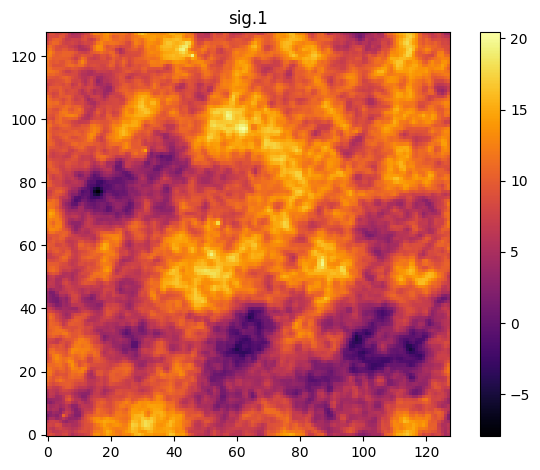

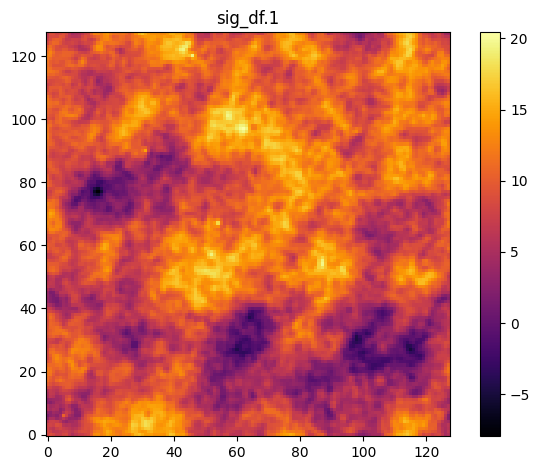

In [5]:
# start with the first yaml-file
yfile = 'config/opt_1.yml'

# initialize the OptimizeKLConfig class with the yaml-file and the builders dictionary
cfg = OptimizeKLConfig.from_file(yfile, builders_dct)

# plot the mock data
data = cfg.instantiate_sec('data')
plot_arr(data, name='data', odir='results')

# initialize all signal models for each iteration
sig_dct = {sec: cfg.instantiate_sec(sec) for sec in cfg.sections if sec.startswith('sig')}

# run the optimization
samples, state = cfg.optimize_kl()

for key,sig in sig_dct.items():
    if set(sig.domain.keys()).issubset(set(samples.pos.tree.keys())):
        res = jft.mean(tuple(sig(s) for s in samples))
        plot_arr(res, name=key, odir='results')

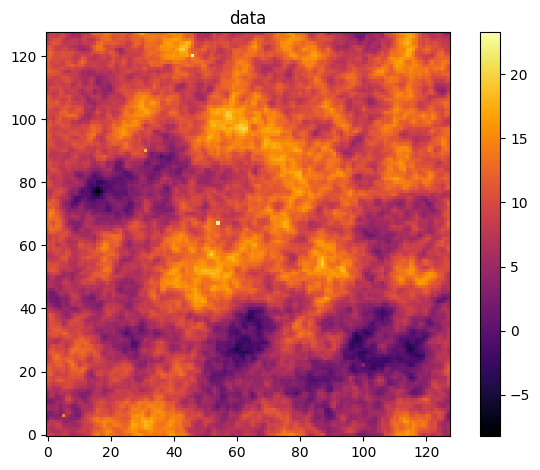

OPTIMIZE_KL: Starting 0004

---
performing transition to update the model params


s != m


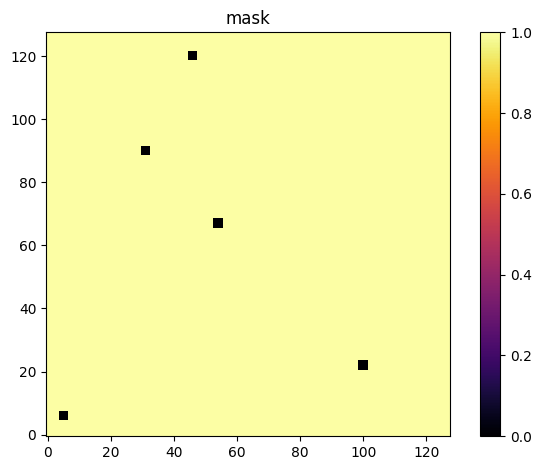

OPTIMIZE_KL: Starting 0001


s == p == set()


N: Iteration Limit Reached!
OPTIMIZE_KL: Iteration 0001 ⛰:+2.6320e+07
OPTIMIZE_KL: Linear sampling status (100,)
OPTIMIZE_KL: #(KL minimization steps) 50
OPTIMIZE_KL: Likelihood residual(s):
'reduced χ²: 3.2e+03± 1.1e+02, avg:     -1.7±     8.6, #dof:  16384'

OPTIMIZE_KL: Prior residual(s):
df.2 asperity           :: 'reduced χ²:    0.67±    0.43, avg:    -0.28±    0.77, #dof:      1'
df.2 flexibility        :: 'reduced χ²:     9.5±     3.1, avg:     -3.0±    0.51, #dof:      1'
df.2 fluctuations       :: 'reduced χ²:     3.5±     3.3, avg:     +1.1±     1.5, #dof:      1'
df.2 loglogavgslope     :: 'reduced χ²:     1.0±    0.63, avg:    +0.96±    0.33, #dof:      1'
df.2 spectrum           :: 'reduced χ²:     1.4±  0.0067, avg:   +0.027±   0.003, #dof:   3238'
df.2 xi                 :: 'reduced χ²:    0.12±  0.0047, avg: +0.00035± 5.8e-05, #dof:  16384'
df.2 zeromode           :: 'reduced χ²:     1.0±     1.0, avg:     -0.7±    0.72, #dof:      1'


OPTIMIZE_KL: Starting 0002
OPTIMI

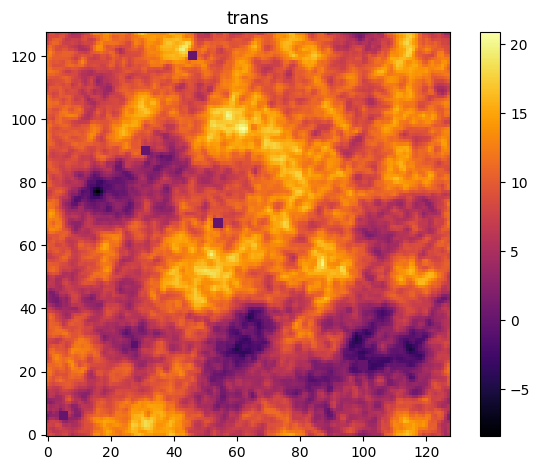

finished transition
---

N: Iteration Limit Reached!
OPTIMIZE_KL: Iteration 0004 ⛰:+1.6964e+05
OPTIMIZE_KL: Linear sampling status (0, 0, 0, 0)
OPTIMIZE_KL: #(KL minimization steps) 50
OPTIMIZE_KL: Likelihood residual(s):
'reduced χ²:   2e+01± 1.1e+01, avg:  +0.0054±    0.79, #dof:  16384'

OPTIMIZE_KL: Prior residual(s):
df.2 asperity           :: 'reduced χ²:    0.26±    0.24, avg:    -0.43±    0.27, #dof:      1'
df.2 flexibility        :: 'reduced χ²: 1.1e+01±     3.4, avg:     -3.3±    0.52, #dof:      1'
df.2 fluctuations       :: 'reduced χ²:    0.18±    0.17, avg:    +0.36±    0.21, #dof:      1'
df.2 loglogavgslope     :: 'reduced χ²:    0.83±    0.21, avg:     +0.9±    0.11, #dof:      1'
df.2 spectrum           :: 'reduced χ²:     1.4±    0.03, avg:   +0.013±   0.012, #dof:   3238'
df.2 xi                 :: 'reduced χ²:    0.13±  0.0039, avg: +0.00088± 0.00016, #dof:  16384'
df.2 zeromode           :: 'reduced χ²:     2.0±     2.3, avg:    -0.77±     1.2, #dof:      1'
ps.2

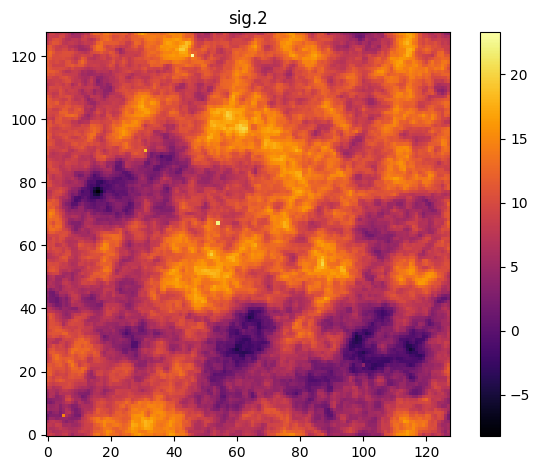

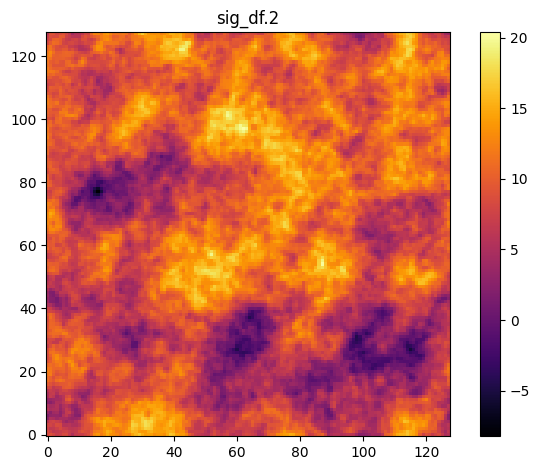

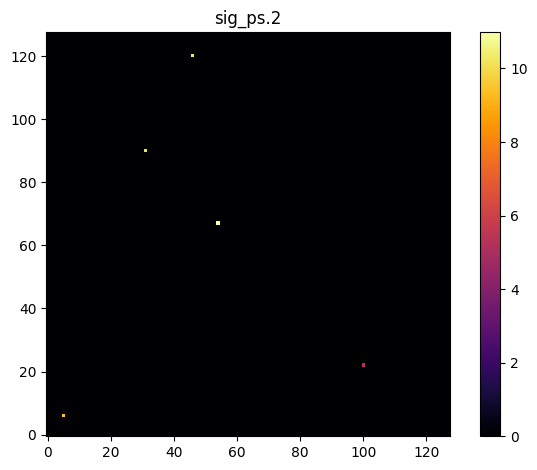

In [6]:
# continue the optimization using the second yaml-file
yfile = 'config/opt_2.yml'

# initialize the OptimizeKLConfig class with the yaml-file and the builders dictionary
cfg = OptimizeKLConfig.from_file(yfile, builders_dct)

# plot the mock data
data = cfg.instantiate_sec('data')
plot_arr(data, name='data', odir='results')

# initialize all signal models for each iteration
sig_dct = {sec: cfg.instantiate_sec(sec) for sec in cfg.sections if sec.startswith('sig')}

# run the optimization
samples, state = cfg.optimize_kl()

for key,sig in sig_dct.items():
    if set(sig.domain.keys()).issubset(set(samples.pos.tree.keys())):
        res = jft.mean(tuple(sig(s) for s in samples))
        plot_arr(res, name=key, odir='results')